In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display
import urllib.parse

p = query.Prometheus('http://192.168.178.67:9090')
step="1s"

DEBUG=False

# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.
NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]
# The default range for sliding window aggregations
DEFAULT_RANGE="10s"

# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = "{devices=\"\"}"

# Styling
sns.set_theme(style="ticks",palette="tab10")
sns.set_style("ticks",{'axes.grid' : True})

# Utils

In [36]:
def remove_meta_columns(df):
    cols = [col for col in df.columns if col not in ['measurement', 'delta', 'seconds']]
    return df[cols]

    
def describe_measurement_dataframe(df):
    display(Markdown("### Total "))
    display(remove_meta_columns(df).describe())
    
    display(Markdown("### Per Measurement"))
    display(df[df.columns.difference(['seconds'])].groupby('measurement').describe().unstack(1))

def fetch_query_range(query, start, end, step=step):
    if DEBUG:
        url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
        print(f"Querying '{query}' from {start} to {end} with step {step}: {url}")
    return p.query_range(query, start, end, step)

def prepare_query_range_as_dataframe(measurement_no, query, start, end, step=step) -> pd.DataFrame:
    # url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
    # print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step}: {url}")
    # metrics = p.query_range(query, start, end, step)
    metrics = fetch_query_range(query, start, end, step)

    # We can't be sure that we have a value for each second, so we calculate the difference between the timestamps
    # and att those to the dataframe
    metrics['tvalue'] = metrics.index
    metrics['delta'] = (metrics['tvalue'] - metrics['tvalue'].min()).fillna(0).astype('timedelta64[s]')
    metrics['seconds'] = metrics['delta'].dt.total_seconds().astype(int)
    metrics.drop(['tvalue'], inplace=True, axis=1)
    # metrics = metrics.assign(seconds=range(len(metrics)))
    metrics = metrics.assign(measurement=measurement_no)
    
    # summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query, df):
    result = [prepare_query_range_as_dataframe(idx, query, start, end) for idx, (start, end) in enumerate(zip(df['Start'], df['End']), 1)]
    result = pd.concat(result)
    return result


# TODO:
def mark_outliers(df, fence=2.22):
    # Select only numeric columns
    cols = df.select_dtypes('number').columns
    df_sub = df.loc[:, cols]
    
    # Calculate IQR
    iqr = df_sub.quantile(0.75, numeric_only=False) - df_sub.quantile(0.25, numeric_only=False)
    lim = np.abs((df_sub - df_sub.median()) / iqr) < fence
    
    # Replace Outliers with NaN
    df.loc[:, cols] = df_sub.where(lim, np.nan)
    
    # Replace all NaN values
    return df


def summarize_outliers(df, fence=2.22):
    marked_outliers = mark_outliers(df, fence)
    diff = df.compare(marked_outliers)
    
    # No Outliers, no problem
    if diff.size == 0:
        return
    
    diff.name = 'Outliers'
    print('Outliers detected, please check manually')
    print(diff)
    

def drop_outliers(df, fence=2.22):
    cols = df.select_dtypes('number').columns
    return mark_outliners(df, fence).dropna(how='any', subset=cols)

# Data Preparation

In [37]:
Q_POWER='{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}'
Q_CPU_SECONDS=f"sum by (mode) (increase(node_cpu_seconds_total[{DEFAULT_RANGE}]))"
Q_CPU_UTILIZATION=f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)"
Q_CPU_FREQUENCY="avg by (instance) (node_cpu_scaling_frequency_hertz)"
Q_MEMORY_USAGE=f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Cached_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Buffers_bytes[{DEFAULT_RANGE}])) / avg_over_time(node_memory_MemTotal_bytes[{DEFAULT_RANGE}])))
    """
Q_NETWORK_RX_BYTES=f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_BYTES=f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_PACKETS=f"sum by(device) (increase(node_network_receive_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_PACKETS=f"sum by(device) (increase(node_network_transmit_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_RATE=f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_NETWORK_TX_RATE=f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_DISK_IO_SECONDS=f"increase(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}])"
Q_DISK_IO_RATE=f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))"
Q_INTERRUPTS=f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{DEFAULT_RANGE}]) > 0)"

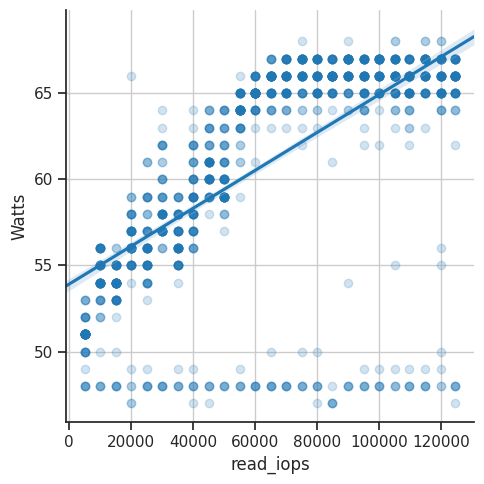

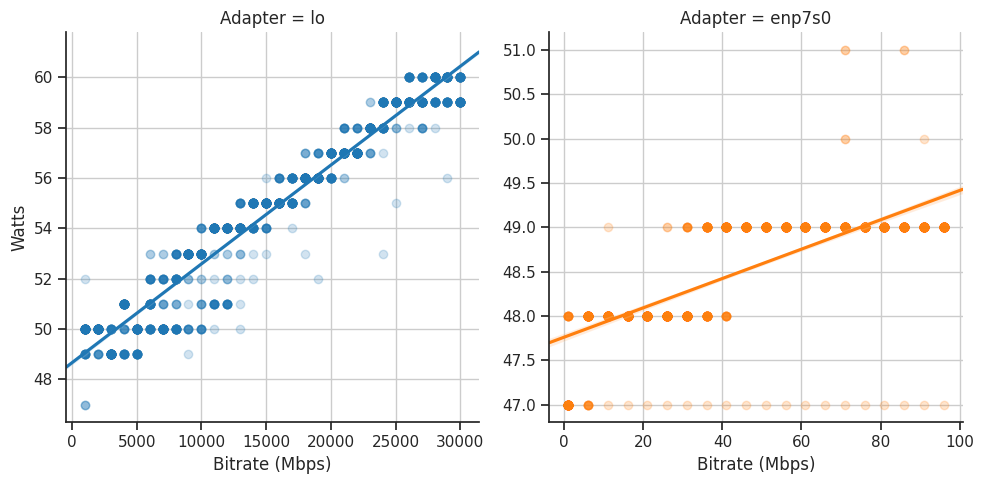

In [55]:
# Disk I/O
fio_results = pd.read_csv('iobench/iobench.csv', sep=';')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end).assign(idx=idx) for idx, (start, end) in enumerate(zip(fio_results['Start'], fio_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

io_results = power_metrics.join(fio_results, on='idx')
io_results=io_results.reset_index()[['Watts', 'read_iops']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=io_results, x="read_iops", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
plt.show(fg)


net_results = pd.read_csv('netbench/netbench-log.csv', sep=',')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end).assign(idx=idx) for idx, (start, end) in enumerate(zip(net_results['Start'], net_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

net_results = power_metrics.join(net_results, on='idx')

net_results=net_results.reset_index()[['Watts', 'Bitrate', 'Adapter']]
net_results['Bitrate'] = net_results['Bitrate'].astype(float).div(1000000) # To Mbps

fg = sns.lmplot(
    data=net_results, x="Bitrate", y="Watts", hue="Adapter", col="Adapter", scatter=True, truncate=False, scatter_kws={'alpha': .2},
    facet_kws=dict(sharex=False, sharey=False),
)
fg.axes[0,0].set_xlabel('Bitrate (Mbps)')
fg.axes[0,1].set_xlabel('Bitrate (Mbps)')
plt.show(fg)

In [39]:
# This is just a try to load everything into a single dataframe.
# It's not working yet, but I'm going to leave it here for now.
def prepare_humongous_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    power_metrics = prepare_dataframe(Q_POWER, df).set_index(['measurement', 'seconds'])
    cpu_seconds = prepare_dataframe("avg by (mode) (node_cpu_seconds_total)", df).set_index(['measurement', 'seconds'])
    memory_free = prepare_dataframe("node_memory_MemFree_bytes", df).set_index(['measurement','seconds'])
    memory_chached = prepare_dataframe("node_memory_Cached_bytes", df).set_index(['measurement','seconds'])
    memory_buffers = prepare_dataframe("node_memory_Buffers_bytes", df).set_index(['measurement', 'seconds'])
    memory_total = prepare_dataframe("node_memory_MemTotal_bytes", df).set_index(['measurement', 'seconds'])
    network_receive_bytes = prepare_dataframe(f"node_network_receive_bytes_total{net_filter_label}", df).set_index(['measurement', 'seconds'])
    network_transmit_bytes = prepare_dataframe(f"node_network_transmit_bytes{net_filter_label}", df).set_index(['measurement', 'seconds'])
    disk_io_time_seconds = prepare_dataframe(f"node_disk_io_time_seconds_total{disk_filter_label}", df).set_index(['measurement', 'seconds'])
    interrupts = prepare_dataframe(f"sum by(devices, type) (node_interrupts_total{interrupts_filter} > 0)", df).set_index(['measurement', 'seconds'])

    df = pd.concat(
        [power_metrics, cpu_seconds, memory_free, memory_chached, memory_buffers, memory_total, network_receive_bytes, network_transmit_bytes, disk_io_time_seconds, interrupts], 
        axis=1,
        names=['measurement', 'seconds']
    )

    return df

# IOPS

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [40]:
bm = pd.read_csv('baseline.csv')
bm

,Start,End,Duration,Energy
0,1681634834,1681635134,5m,4


## Power Stats

In [41]:
power_metrics = prepare_dataframe(Q_POWER, bm)
describe_measurement_dataframe(power_metrics)

mean_per_second = power_metrics.groupby(by=['seconds']).mean()
display(mean_per_second.describe())


# printmd("### Current Measurment Plots")
# fg = sns.lmplot(
#       data=power_metrics, x="seconds", y="Current", col="measurement", col_wrap=5, height=3, scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Current (A)")
# plt.show(fg)

# printmd("### Voltage Measurment Plots")
# fg = sns.lmplot(
#     data=power_metrics, x="seconds", y="Voltage", col="measurement", col_wrap=5, height=3, scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Voltage (V)")
# plt.show(fg)

# printmd("### Watts Measurment Plots")
# fg = sns.lmplot(
#       data=power_metrics, x="seconds", y="Watts", col="measurement", col_wrap=5, height=3, scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Watts (W)")
# plt.show(fg)        

# printmd("### Mean Watts")

# mean_per_second = power_metrics.groupby(by=['seconds']).mean()
# display(mean_per_second.describe())

# fig = mean_per_second['Watts'].plot(drawstyle='steps')
# fig.set_xlabel("Time (s)")
# fig.set_ylabel("Watts (W)")
# plt.show(fig)

# fg = sns.lmplot(
#       data=mean_per_second.reset_index(), x="seconds", y="Watts", scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Watts (W)")
# plt.show(fg)    

### Total 

,"epc1202Current{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}","epc1202PowerActive{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}","epc1202Voltage{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}"
count,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203
std,0.786951,0.497034,0.427307
min,261.000000,47.000000,237.000000
25%,262.000000,47.000000,237.000000
50%,262.000000,47.000000,237.000000
75%,263.000000,48.000000,237.000000
max,265.000000,48.000000,238.000000


### Per Measurement

                                                                                  measurement
delta                                                                      count  1                          301
                                                                           mean   1              0 days 00:02:30
                                                                           std    1              0 days 00:01:27
                                                                           min    1              0 days 00:00:00
                                                                           25%    1              0 days 00:01:15
                                                                           50%    1              0 days 00:02:30
                                                                           75%    1              0 days 00:03:45
                                                                           max    1              0 days 00:05:00
ep

,"epc1202Current{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}","epc1202PowerActive{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}","epc1202Voltage{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}",delta,measurement
count,301.000000,301.000000,301.000000,301,301.0
mean,262.259136,47.438538,237.239203,0 days 00:02:30,1.0
std,0.786951,0.497034,0.427307,0 days 00:01:27,0.0
min,261.000000,47.000000,237.000000,0 days 00:00:00,1.0
25%,262.000000,47.000000,237.000000,0 days 00:01:15,1.0
50%,262.000000,47.000000,237.000000,0 days 00:02:30,1.0
75%,263.000000,48.000000,237.000000,0 days 00:03:45,1.0
max,265.000000,48.000000,238.000000,0 days 00:05:00,1.0


## CPU

### CPU Time

In [42]:
cpu_metrics = prepare_dataframe(Q_CPU_SECONDS, bm)
describe_measurement_dataframe(cpu_metrics)

total_mean_result = remove_meta_columns(cpu_metrics).groupby(level=0).mean()

display(total_mean_result)
# total_mean_result.plot.bar(ylabel='CPU seconds')

### Total 

,"{mode=""idle""}","{mode=""iowait""}","{mode=""irq""}","{mode=""nice""}","{mode=""softirq""}","{mode=""steal""}","{mode=""system""}","{mode=""user""}"
count,301.000000,301.000000,301.0,301.0,301.000000,301.0,301.000000,301.000000
mean,159.052123,0.001661,0.0,0.0,0.019454,0.0,0.109708,0.665891
std,0.132134,0.004268,0.0,0.0,0.016928,0.0,0.022709,0.058350
min,158.522222,0.000000,0.0,0.0,0.000000,0.0,0.044444,0.511111
25%,158.977778,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.633333
50%,159.044444,0.000000,0.0,0.0,0.022222,0.0,0.111111,0.677778
75%,159.122222,0.000000,0.0,0.0,0.033333,0.0,0.122222,0.711111
max,159.744444,0.022222,0.0,0.0,0.066667,0.0,0.177778,0.788889


### Per Measurement

                      measurement
delta          count  1                          301
               mean   1              0 days 00:02:30
               std    1              0 days 00:01:27
               min    1              0 days 00:00:00
               25%    1              0 days 00:01:15
                                          ...       
{mode="user"}  min    1                     0.511111
               25%    1                     0.633333
               50%    1                     0.677778
               75%    1                     0.711111
               max    1                     0.788889
Length: 72, dtype: object

,"{mode=""idle""}","{mode=""iowait""}","{mode=""irq""}","{mode=""nice""}","{mode=""softirq""}","{mode=""steal""}","{mode=""system""}","{mode=""user""}"
2023-04-16 08:47:14,158.977778,0.0,0.0,0.0,0.000000,0.0,0.100000,0.722222
2023-04-16 08:47:15,159.133333,0.0,0.0,0.0,0.000000,0.0,0.100000,0.722222
2023-04-16 08:47:16,159.000000,0.0,0.0,0.0,0.000000,0.0,0.077778,0.722222
2023-04-16 08:47:17,159.244444,0.0,0.0,0.0,0.000000,0.0,0.088889,0.666667
2023-04-16 08:47:18,159.044444,0.0,0.0,0.0,0.000000,0.0,0.088889,0.677778
...,...,...,...,...,...,...,...,...
2023-04-16 08:52:10,159.188889,0.0,0.0,0.0,0.033333,0.0,0.111111,0.577778
2023-04-16 08:52:11,159.022222,0.0,0.0,0.0,0.033333,0.0,0.111111,0.644444
2023-04-16 08:52:12,158.522222,0.0,0.0,0.0,0.033333,0.0,0.100000,0.577778
2023-04-16 08:52:13,159.188889,0.0,0.0,0.0,0.022222,0.0,0.111111,0.533333


### CPU Utilization

In [43]:
cpu_utilization = prepare_dataframe(Q_CPU_UTILIZATION, bm)
describe_measurement_dataframe(cpu_utilization)

grouped_mean = cpu_utilization.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

### Total 

,"{mode=""idle""}","{mode=""iowait""}","{mode=""irq""}","{mode=""nice""}","{mode=""softirq""}","{mode=""steal""}","{mode=""system""}","{mode=""user""}"
count,301.000000,301.000000,301.0,301.0,301.000000,301.0,301.000000,301.000000
mean,99.407577,0.001038,0.0,0.0,0.012159,0.0,0.068568,0.416182
std,0.082584,0.002668,0.0,0.0,0.010580,0.0,0.014193,0.036469
min,99.076389,0.000000,0.0,0.0,0.000000,0.0,0.027778,0.319444
25%,99.361111,0.000000,0.0,0.0,0.000000,0.0,0.062500,0.395833
50%,99.402778,0.000000,0.0,0.0,0.013889,0.0,0.069444,0.423611
75%,99.451389,0.000000,0.0,0.0,0.020833,0.0,0.076389,0.444444
max,99.840278,0.013889,0.0,0.0,0.041667,0.0,0.111111,0.493056


### Per Measurement

                      measurement
delta          count  1                          301
               mean   1              0 days 00:02:30
               std    1              0 days 00:01:27
               min    1              0 days 00:00:00
               25%    1              0 days 00:01:15
                                          ...       
{mode="user"}  min    1                     0.319444
               25%    1                     0.395833
               50%    1                     0.423611
               75%    1                     0.444444
               max    1                     0.493056
Length: 72, dtype: object

## Memory

In [44]:
memory_usage = prepare_dataframe(Q_MEMORY_USAGE, bm)
describe_measurement_dataframe(memory_usage)

grouped_mean = memory_usage.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

### Total 

,"{instance=""192.168.178.79:9100"",job=""node""}"
count,301.000000
mean,1.063313
std,0.004534
min,1.055603
25%,1.059990
50%,1.063192
75%,1.065911
max,1.077417


### Per Measurement

                                                    measurement
delta                                        count  1                          301
                                             mean   1              0 days 00:02:30
                                             std    1              0 days 00:01:27
                                             min    1              0 days 00:00:00
                                             25%    1              0 days 00:01:15
                                             50%    1              0 days 00:02:30
                                             75%    1              0 days 00:03:45
                                             max    1              0 days 00:05:00
{instance="192.168.178.79:9100",job="node"}  count  1                        301.0
                                             mean   1                     1.063313
                                             std    1                     0.004534
                       

## Network

### Received KBytes

In [45]:
network_received_bytes = prepare_dataframe(Q_NETWORK_RX_BYTES, bm)
describe_measurement_dataframe(network_received_bytes)

grouped_mean = network_received_bytes.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
# grouped_mean.plot.bar(ylabel='Received KBytes')

### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}"
count,301.0,301.000000,301.0
mean,0.0,10.455526,0.0
std,0.0,0.439885,0.0
min,0.0,9.446667,0.0
25%,0.0,10.124444,0.0
50%,0.0,10.426667,0.0
75%,0.0,10.733333,0.0
max,0.0,11.573333,0.0


### Per Measurement

                           measurement
delta               count  1                          301
                    mean   1              0 days 00:02:30
                    std    1              0 days 00:01:27
                    min    1              0 days 00:00:00
                    25%    1              0 days 00:01:15
                    50%    1              0 days 00:02:30
                    75%    1              0 days 00:03:45
                    max    1              0 days 00:05:00
{device="docker0"}  count  1                        301.0
                    mean   1                          0.0
                    std    1                          0.0
                    min    1                          0.0
                    25%    1                          0.0
                    50%    1                          0.0
                    75%    1                          0.0
                    max    1                          0.0
{device="enp7s0"}   count  1     

In [46]:
network_average_receive_rate = prepare_dataframe(Q_NETWORK_RX_RATE, bm)
describe_measurement_dataframe(network_average_receive_rate)

grouped_mean = network_average_receive_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}"
count,301.0,301.000000,301.0
mean,0.0,1045.552602,0.0
std,0.0,43.988468,0.0
min,0.0,944.666667,0.0
25%,0.0,1012.444444,0.0
50%,0.0,1042.666667,0.0
75%,0.0,1073.333333,0.0
max,0.0,1157.333333,0.0


### Per Measurement

                           measurement
delta               count  1                          301
                    mean   1              0 days 00:02:30
                    std    1              0 days 00:01:27
                    min    1              0 days 00:00:00
                    25%    1              0 days 00:01:15
                    50%    1              0 days 00:02:30
                    75%    1              0 days 00:03:45
                    max    1              0 days 00:05:00
{device="docker0"}  count  1                        301.0
                    mean   1                          0.0
                    std    1                          0.0
                    min    1                          0.0
                    25%    1                          0.0
                    50%    1                          0.0
                    75%    1                          0.0
                    max    1                          0.0
{device="enp7s0"}   count  1     

### Sent KByte

In [47]:
network_transmitted_bytes = prepare_dataframe(Q_NETWORK_TX_BYTES, bm)
describe_measurement_dataframe(network_transmitted_bytes)

grouped_mean = network_transmitted_bytes.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
# grouped_mean.plot.bar(ylabel='Sent KBytes')

### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}"
count,301.0,301.000000,301.0
mean,0.0,198.135947,0.0
std,0.0,0.080701,0.0
min,0.0,197.851111,0.0
25%,0.0,198.084444,0.0
50%,0.0,198.142222,0.0
75%,0.0,198.190000,0.0
max,0.0,198.358889,0.0


### Per Measurement

                           measurement
delta               count  1                          301
                    mean   1              0 days 00:02:30
                    std    1              0 days 00:01:27
                    min    1              0 days 00:00:00
                    25%    1              0 days 00:01:15
                    50%    1              0 days 00:02:30
                    75%    1              0 days 00:03:45
                    max    1              0 days 00:05:00
{device="docker0"}  count  1                        301.0
                    mean   1                          0.0
                    std    1                          0.0
                    min    1                          0.0
                    25%    1                          0.0
                    50%    1                          0.0
                    75%    1                          0.0
                    max    1                          0.0
{device="enp7s0"}   count  1     

In [48]:
network_average_transmit_rate = prepare_dataframe(Q_NETWORK_TX_RATE, bm)
describe_measurement_dataframe(network_average_transmit_rate)

grouped_mean = network_average_transmit_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}"
count,301.0,301.000000,301.0
mean,0.0,19813.594684,0.0
std,0.0,8.070060,0.0
min,0.0,19785.111111,0.0
25%,0.0,19808.444444,0.0
50%,0.0,19814.222222,0.0
75%,0.0,19819.000000,0.0
max,0.0,19835.888889,0.0


### Per Measurement

                           measurement
delta               count  1                          301
                    mean   1              0 days 00:02:30
                    std    1              0 days 00:01:27
                    min    1              0 days 00:00:00
                    25%    1              0 days 00:01:15
                    50%    1              0 days 00:02:30
                    75%    1              0 days 00:03:45
                    max    1              0 days 00:05:00
{device="docker0"}  count  1                        301.0
                    mean   1                          0.0
                    std    1                          0.0
                    min    1                          0.0
                    25%    1                          0.0
                    50%    1                          0.0
                    75%    1                          0.0
                    max    1                          0.0
{device="enp7s0"}   count  1     

# Disk

In [49]:
total_disk_io_seconds = prepare_dataframe(Q_DISK_IO_SECONDS, bm)

grouped_result = total_disk_io_seconds.groupby(level=0).mean()
display(grouped_result)

,"{device=""sda"",instance=""192.168.178.79:9100"",job=""node""}",delta,seconds,measurement
2023-04-16 08:47:14,0.0,0 days 00:00:00,0.0,1.0
2023-04-16 08:47:15,0.0,0 days 00:00:01,1.0,1.0
2023-04-16 08:47:16,0.0,0 days 00:00:02,2.0,1.0
2023-04-16 08:47:17,0.0,0 days 00:00:03,3.0,1.0
2023-04-16 08:47:18,0.0,0 days 00:00:04,4.0,1.0
...,...,...,...,...
2023-04-16 08:52:10,0.0,0 days 00:04:56,296.0,1.0
2023-04-16 08:52:11,0.0,0 days 00:04:57,297.0,1.0
2023-04-16 08:52:12,0.0,0 days 00:04:58,298.0,1.0
2023-04-16 08:52:13,0.0,0 days 00:04:59,299.0,1.0


In [50]:
disk_io_rate = prepare_dataframe(Q_DISK_IO_RATE, bm)
describe_measurement_dataframe(power_metrics)

grouped_mean = disk_io_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='I/O seconds')

### Total 

,"epc1202Current{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}","epc1202PowerActive{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}","epc1202Voltage{epc1202PowerIndex=""1"",instance=""pdu.local"",job=""snmp""}"
count,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203
std,0.786951,0.497034,0.427307
min,261.000000,47.000000,237.000000
25%,262.000000,47.000000,237.000000
50%,262.000000,47.000000,237.000000
75%,263.000000,48.000000,237.000000
max,265.000000,48.000000,238.000000


### Per Measurement

                                                                                  measurement
delta                                                                      count  1                          301
                                                                           mean   1              0 days 00:02:30
                                                                           std    1              0 days 00:01:27
                                                                           min    1              0 days 00:00:00
                                                                           25%    1              0 days 00:01:15
                                                                           50%    1              0 days 00:02:30
                                                                           75%    1              0 days 00:03:45
                                                                           max    1              0 days 00:05:00
ep

# Interrupts

In [51]:
interrupts = prepare_dataframe(Q_INTERRUPTS, bm)
describe_measurement_dataframe(interrupts)

grouped_mean = interrupts.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
display(grouped_mean)
# grouped_mean.plot.bar(ylabel='Interrupts')

### Total 

,"{type=""CAL""}","{type=""LOC""}","{type=""MCP""}","{type=""RES""}","{type=""TLB""}"
count,301.000000,301.000000,1.0,301.000000,103.000000
mean,62.375415,331.524917,16.0,2.641196,6.087379
std,29.139354,154.011808,NaN,4.332532,4.850928
min,13.000000,82.000000,16.0,1.000000,1.000000
25%,40.000000,220.000000,16.0,2.000000,2.000000
50%,57.000000,308.000000,16.0,2.000000,5.000000
75%,80.000000,428.000000,16.0,2.000000,9.000000
max,138.000000,778.000000,16.0,58.000000,27.000000


### Per Measurement

                     measurement
delta         count  1                          301
              mean   1              0 days 00:02:30
              std    1              0 days 00:01:27
              min    1              0 days 00:00:00
              25%    1              0 days 00:01:15
              50%    1              0 days 00:02:30
              75%    1              0 days 00:03:45
              max    1              0 days 00:05:00
{type="CAL"}  count  1                        301.0
              mean   1                    62.375415
              std    1                    29.139354
              min    1                         13.0
              25%    1                         40.0
              50%    1                         57.0
              75%    1                         80.0
              max    1                        138.0
{type="LOC"}  count  1                        301.0
              mean   1                   331.524917
              std    1         

,"{type=""CAL""}","{type=""LOC""}","{type=""MCP""}","{type=""RES""}","{type=""TLB""}",delta,seconds
2023-04-16 08:47:14,127.0,525.0,NaN,2.0,21.0,0 days 00:00:00,0.0
2023-04-16 08:47:15,62.0,342.0,NaN,2.0,NaN,0 days 00:00:01,1.0
2023-04-16 08:47:16,51.0,318.0,NaN,2.0,NaN,0 days 00:00:02,2.0
2023-04-16 08:47:17,71.0,282.0,NaN,2.0,NaN,0 days 00:00:03,3.0
2023-04-16 08:47:18,74.0,441.0,NaN,2.0,NaN,0 days 00:00:04,4.0
...,...,...,...,...,...,...,...
2023-04-16 08:52:10,67.0,408.0,NaN,2.0,NaN,0 days 00:04:56,296.0
2023-04-16 08:52:11,40.0,190.0,NaN,2.0,NaN,0 days 00:04:57,297.0
2023-04-16 08:52:12,37.0,185.0,NaN,2.0,NaN,0 days 00:04:58,298.0
2023-04-16 08:52:13,55.0,304.0,NaN,2.0,10.0,0 days 00:04:59,299.0


# Software Experiment

In [52]:
# Those are the variants we have measured
VARIANTS=["no-cache", "caffeine-cache", "redis-cache", "caffeine-redis-cache"]
data_measurement = pd.read_csv("benchmark-log.csv")

## Power Consumption

### Raw Data Samples

,index,Power,Watts,Voltage,delta,seconds,measurement,variant
0,2023-04-21 08:33:49,266.0,48.0,237.0,0 days 00:00:00,0,1,no-cache
1,2023-04-21 08:33:50,266.0,48.0,238.0,0 days 00:00:01,1,1,no-cache
2,2023-04-21 08:33:51,269.0,49.0,238.0,0 days 00:00:02,2,1,no-cache
3,2023-04-21 08:33:52,266.0,48.0,238.0,0 days 00:00:03,3,1,no-cache
4,2023-04-21 08:33:53,450.0,94.0,237.0,0 days 00:00:04,4,1,no-cache
...,...,...,...,...,...,...,...,...
14514,2023-04-22 07:30:13,289.0,55.0,239.0,0 days 00:01:48,108,32,caffeine-redis-cache
14515,2023-04-22 07:30:14,289.0,55.0,239.0,0 days 00:01:49,109,32,caffeine-redis-cache
14516,2023-04-22 07:30:15,289.0,55.0,239.0,0 days 00:01:50,110,32,caffeine-redis-cache
14517,2023-04-22 07:30:16,290.0,55.0,239.0,0 days 00:01:51,111,32,caffeine-redis-cache


### Wattage

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,3633.0,54.074043,6.847599,47.0,51.0,53.0,55.0,95.0
caffeine-redis-cache,3631.0,53.993390,5.927799,47.0,51.0,54.0,55.0,95.0
no-cache,3622.0,58.306184,7.458093,47.0,57.0,58.0,58.0,94.0
redis-cache,3633.0,55.320121,6.039169,47.0,51.0,56.0,57.0,96.0


### See the distribution of the measurements

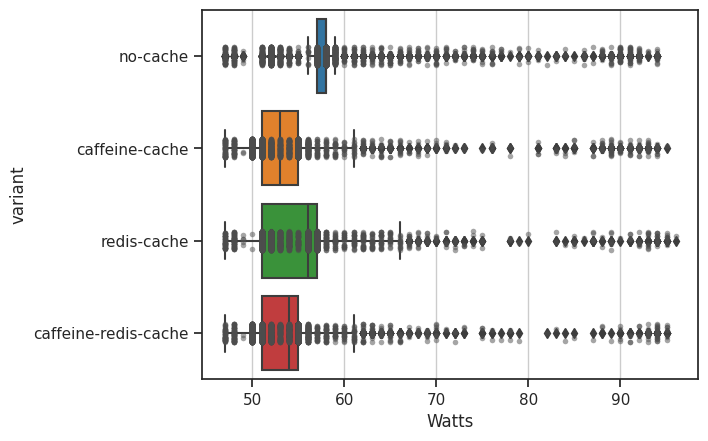

### See how the variants behave over time

<Figure size 1000x300 with 0 Axes>

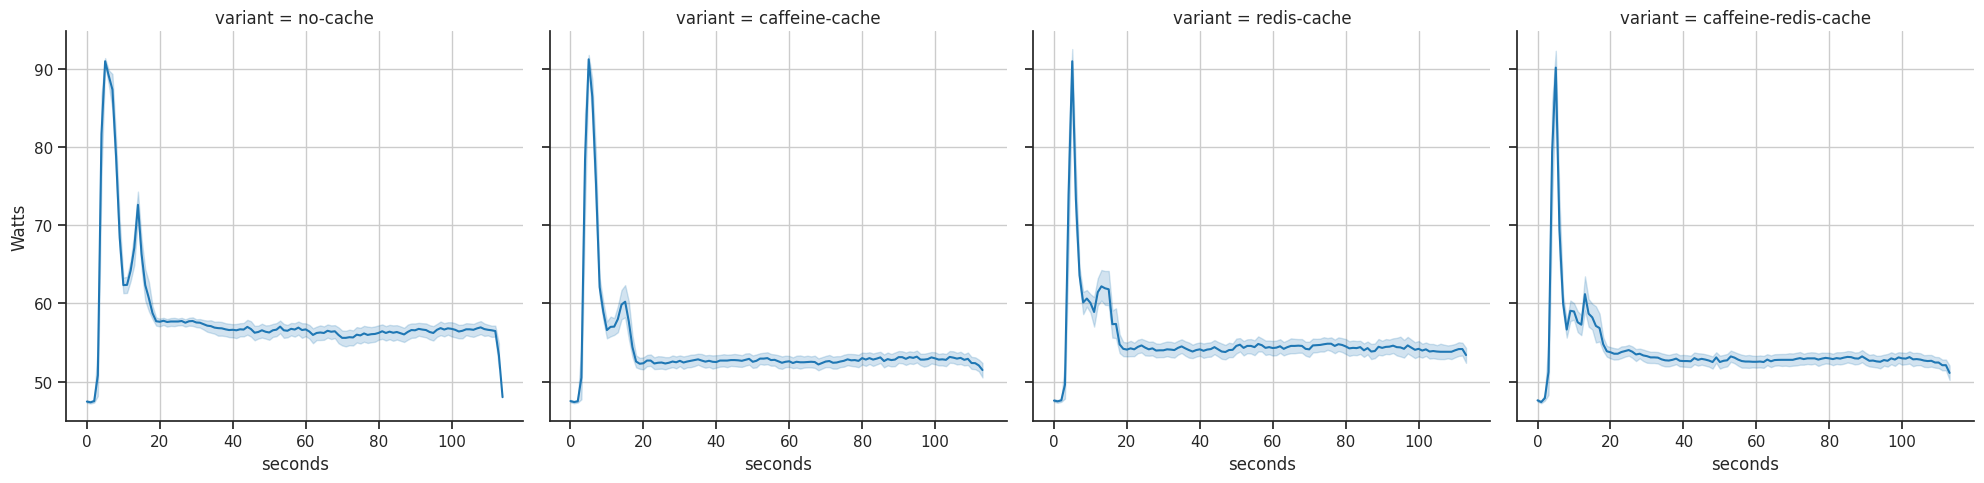

### Compare the variants over time

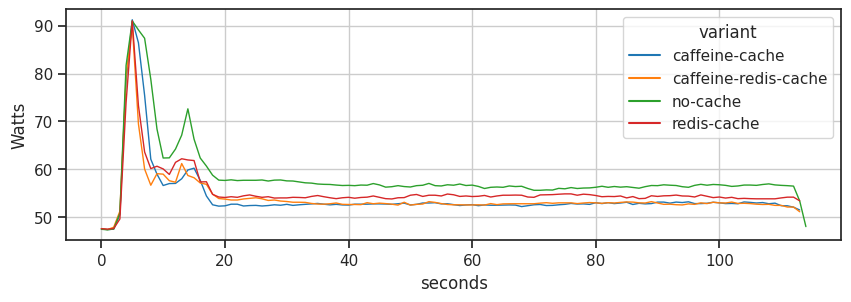

### Linear regression

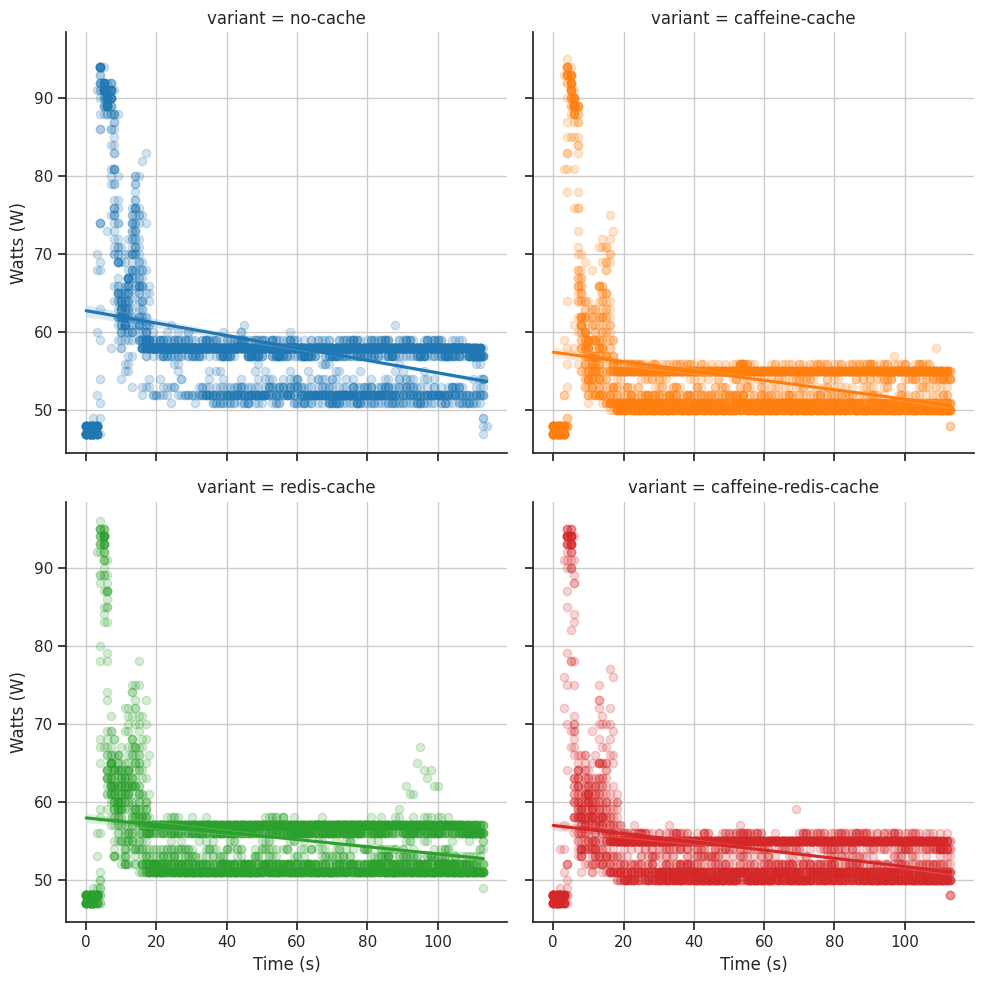

In [53]:
POWER_METRICS = pd.concat([prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in VARIANTS])
POWER_METRICS.columns.values[0] = "Power"
POWER_METRICS.columns.values[1] = "Watts"
POWER_METRICS.columns.values[2] = "Voltage"

display(Markdown("## Power Consumption"))
POWER_METRICS.reset_index(inplace=True)

display(Markdown("### Raw Data Samples"))
display(POWER_METRICS)

display(Markdown("### Wattage"))
display(POWER_METRICS.groupby(by=['variant'])['Watts'].describe())

# Boxplot
display(Markdown("### See the distribution of the measurements"))
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS)
sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)

# Lineplot of measurment distribution
display(Markdown("### See how the variants behave over time"))
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=POWER_METRICS, x="seconds", y="Watts", col="variant", kind="line"
)
plt.show(f)

# Lineplot
display(Markdown("### Compare the variants over time"))
f = plt.figure(figsize=(10,3))
MEAN_POWER_METRICS=POWER_METRICS.groupby(by=['variant', 'seconds']).mean()
sns.lineplot(data=MEAN_POWER_METRICS, x="seconds", y="Watts", hue="variant", linewidth=1)
plt.show(f)

# Linear regression
display(Markdown("### Linear regression"))
fg = sns.lmplot(
    data=POWER_METRICS, x="seconds", y="Watts", hue="variant", col="variant", col_wrap=2,
    scatter_kws={'alpha': .2}
    
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("Watts (W)")
plt.show(fg)

count         mean        std      min   
variant              mode                                              
caffeine-cache       idle      32.0  1590.566875  14.392871  1561.48  \
                     iowait    32.0     0.299687   0.030531     0.25   
                     irq       32.0     0.000000   0.000000     0.00   
                     nice      32.0     0.000000   0.000000     0.00   
                     softirq   32.0    69.619375   6.453649    58.88   
                     steal     32.0     0.000000   0.000000     0.00   
                     system    32.0    55.991563   3.694694    49.78   
                     user      32.0   101.566250   4.435404    93.42   
caffeine-redis-cache idle      32.0  1600.512500  17.761317  1570.01   
                     iowait    32.0     0.134375   0.026143     0.09   
                     irq       32.0     0.000000   0.000000     0.00   
                     nice      32.0     0.036250   0.205061     0.00   
                     softirq   32.0    69.395625   5.510744    54.89   
                     steal     32.0     0.000000   0.000000     0.00   
                     system    32.0    54.293125   4.458703    36.44   
                     user      32.0    93.640625   3.968186    86.50   
no-cache             idle      32.0  1488.587812  17.805370  1444.02   
                     iowait    32.0     0.280937   0.025572     0.24   
                     irq       32.0     0.000000   0.000000     0.00   
                     nice      32.0     0.000000   0.000000     0.00   
                     softirq   32.0    82.688125   6.274491    70.90   
                     steal     32.0     0.000000   0.000000     0.00   
                     system    32.0    64.651563   3.807307    47.69   
                     user      32.0   192.707812   7.015693   178.50   
redis-cache          idle      32.0  1547.199687  16.396108  1516.77   
                     iowait    32.0     0.147500   0.073660     0.08   
                     irq       32.0     0.000000   0.000000     0.00   
                     nice      32.0     0.120000   0.666164     0.00   
                     softirq   32.0    83.686563   6.535777    72.21   
                     steal     32.0     0.000000   0.000000     0.00   
                     system    32.0    63.919688   3.001529    57.58   
                     user      32.0   134.459375   5.626568   124.57   

                                    25%       50%        75%      max  
variant              mode                                              
caffeine-cache       idle     1580.2675  1591.200  1600.7725  1614.08  
                     iowait      0.2800     0.300     0.3100     0.42  
                     irq         0.0000     0.000     0.0000     0.00  
                     nice        0.0000     0.000     0.0000     0.00  
                     softirq    64.4750    70.455    75.4200    78.03  
                     steal       0.0000     0.000     0.0000     0.00  
                     system     52.8000    56.410    59.0925    61.49  
                     user       98.4250   101.105   105.9525   108.59  
caffeine-redis-cache idle     1587.3600  1597.735  1613.0750  1647.88  
                     iowait      0.1200     0.130     0.1425     0.22  
                     irq         0.0000     0.000     0.0000     0.00  
                     nice        0.0000     0.000     0.0000     1.16  
                     softirq    65.3125    69.375    74.0800    78.55  
                     steal       0.0000     0.000     0.0000     0.00  
                     system     52.5750    54.415    57.6125    60.67  
                     user       90.2600    93.625    97.3175   100.88  
no-cache             idle     1478.2800  1490.685  1498.8950  1530.05  
                     iowait      0.2700     0.280     0.2900     0.34  
                     irq         0.0000     0.000     0.0000     0.00  
                     nice        0.0000     0.000     0.0000     0.00

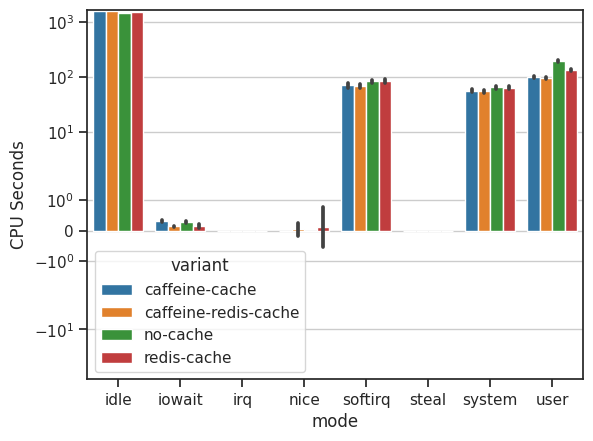

In [54]:
CPU_SECONDS = pd.concat(
    [prepare_dataframe("sum by (mode) (node_cpu_seconds_total)", data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in VARIANTS]
    )
CPU_SECONDS.columns.values[0] = "idle"
CPU_SECONDS.columns.values[1] = "iowait"
CPU_SECONDS.columns.values[2] = "irq"
CPU_SECONDS.columns.values[3] = "nice"
CPU_SECONDS.columns.values[4] = "softirq"
CPU_SECONDS.columns.values[5] = "steal"
CPU_SECONDS.columns.values[6] = "system"
CPU_SECONDS.columns.values[7] = "user"
# I have tried to do that with grouping but idk how to do it
GROUPED=CPU_SECONDS.groupby(by=['variant', 'measurement'])
CPU_SECONDS['idle'] = (CPU_SECONDS['idle'] - GROUPED['idle'].shift()).fillna(0)
CPU_SECONDS['iowait'] = (CPU_SECONDS['iowait'] - GROUPED['iowait'].shift()).fillna(0)
CPU_SECONDS['irq'] = (CPU_SECONDS['irq'] - GROUPED['irq'].shift()).fillna(0)
CPU_SECONDS['nice'] = (CPU_SECONDS['nice'] - GROUPED['nice'].shift()).fillna(0)
CPU_SECONDS['softirq'] = (CPU_SECONDS['softirq'] - GROUPED['softirq'].shift()).fillna(0)
CPU_SECONDS['steal'] = (CPU_SECONDS['steal'] - GROUPED['steal'].shift()).fillna(0)
CPU_SECONDS['system'] = (CPU_SECONDS['system'] - GROUPED['system'].shift()).fillna(0)
CPU_SECONDS['user'] = (CPU_SECONDS['user'] - GROUPED['user'].shift()).fillna(0)
CPU_SECONDS=CPU_SECONDS.melt(
    value_vars=['idle', 'iowait', 'irq', 'nice', 'softirq', 'steal', 'system', 'user'], 
    id_vars=['seconds', 'variant', 'measurement'], 
    var_name='mode', 
    value_name='CPU Seconds')
CPU_SECONDS=CPU_SECONDS.groupby(
    by=['variant', 'mode', 'measurement']).sum()
CPU_SECONDS.reset_index(inplace=True)
display(CPU_SECONDS.groupby(by=['variant', 'mode'])['CPU Seconds'].describe())

g = sns.barplot(
    data=CPU_SECONDS, x="mode", y="CPU Seconds", hue="variant", errorbar="sd"
)
g.set_yscale("symlog")